<a href="https://colab.research.google.com/github/Gunashekhar007/WSAI-intern-2025/blob/main/examples/notebooks/EarlyStopping_LBFO_pv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 47.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


# Early stopping Demo 1: LBFO dataset

This is a short demo for the improved AtomAI model. The model has several additions, such as
- Early stopping
- Automatic binary thresholding
- Weight Decay

The data is of an experimental image with the coordinates of atoms in that image.

In [1]:
!pip install setuptools==65.5.0 wheel==0.38.4 #run this cell incase there is trouble in installing the Github package

Install the latest AtomAI version with additional features such as

- Early stopping
- Auto-thresholding
- Weight decay

In [2]:
!pip install git+https://github.com/Pragalbhv/atomai # install the latest version from source

  Cloning https://github.com/Pragalbhv/atomai to /tmp/pip-req-build-dtfwzish
  Running command git clone --filter=blob:none --quiet https://github.com/Pragalbhv/atomai /tmp/pip-req-build-dtfwzish
  Resolved https://github.com/Pragalbhv/atomai to commit 332eb384645c5a46eda9f6068661ad212737e6e0
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6

In [3]:
# import all necessay libraries.
from atomai.utils import create_lattice_mask, extract_patches_
from atomai.transforms import datatransform
import numpy as np

import atomai as aoi

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
download_link = 'https://drive.google.com/uc?id=1_uo7BXjDU-laUAs4Uj1aFqwqfnxi9tpz'
!gdown $download_link -O 'img_w_coord.npy'
img_w_coord = np.load('img_w_coord.npy')
lattice_im = img_w_coord['lattice_img']
xy_atoms_a = img_w_coord['lattice_coord_a']
xy_atoms_b = img_w_coord['lattice_coord_b']

Downloading...
From (original): https://drive.google.com/uc?id=1_uo7BXjDU-laUAs4Uj1aFqwqfnxi9tpz
From (redirected): https://drive.google.com/uc?id=1_uo7BXjDU-laUAs4Uj1aFqwqfnxi9tpz&confirm=t&uuid=d6d6830a-00b4-46f7-afca-8c9b27247030
To: /content/img_w_coord.npy
100% 118M/118M [00:02<00:00, 45.5MB/s]


Here we have a single image (```lattice_im```) that shows atomic structure of a ferroelectric material with two sublattices whose coordinates are stored in two different arrays (```xy_atoms_a```, ```xy_atoms_b```). We start by creating two separate masks for the two lattices using ```create_lattice_mask``` utility function. Each mask represents circular objects with constant pixel values centered around the centers of atoms. The image and coordinates were provided by C. Nelson (ORNL).

In [5]:
lattice_mask_a = create_lattice_mask(lattice_im, xy_atoms_a.T)
lattice_mask_b = create_lattice_mask(lattice_im, xy_atoms_b.T)

Here we use the atomai function for mask creation (one could define their own custom function) creates an atom-mask pair for each xy coordinate.

In [6]:
multiclass = True

if multiclass:
    lattice_mask_backgr = 1 - (lattice_mask_a + lattice_mask_b)
    lattice_mask = np.concatenate(
        (lattice_mask_a[..., None],
         lattice_mask_b[..., None],
         lattice_mask_backgr[..., None]), # we need to add a background class
        axis=-1)
else:
    lattice_mask = lattice_mask_a + lattice_mask_b
    lattice_mask[lattice_mask>1] = 1

## Generate image-label pairs
images_all, labels_all = extract_patches_(
    lattice_im, lattice_mask, patch_size=256, num_patches=1500, random_state=42)


images_all, images_test_all, labels_all, labels_test_all = train_test_split(
    images_all, labels_all, test_size=0.2, random_state=42)


images_all, images_val_all, labels_all, labels_val_all = train_test_split(
    images_all, labels_all, test_size=0.25, random_state=42)

We set values for data-augmentation here. By changing the values here you can generate images according to how you want the data to change. \\

In our study we modified the test data as well, as we tested the performance of our model at its limits.

In [7]:
# For a single class case, we still need to explicitly specify the single channel
labels_all = labels_all[..., None] if np.ndim(labels_all) == 3 else labels_all
# Number of channels in masked data (the training images have a single channel)
ch = labels_all.shape[-1]
# Define image distortion/noise parameters
zoom = 1.1 # zoom factor
poisson = [30, 40] # P noise range (scaled units)
gauss = [20, 100] # G noise range (scaled units)
blur = [1, 40] # Blurring range (scaled units)
contrast = [5, 14] # contrast range (< 10 is brighter, > 10 is darker)
salt_and_pepper = [1, 10] # min/max amount of salted/peppered pixels (scaled units)

In [8]:
import numpy as np
# Run the augmentor
imaug = datatransform(
    n_channels=ch, dim_order_in='channel_last', dim_order_out='channel_first',
    gauss_noise=gauss, poisson_noise=poisson, salt_and_pepper=salt_and_pepper,
    contrast=contrast, blur=blur, zoom=zoom, rotation=True,
    squeeze_channels=True, seed=42)
images, labels = imaug.run(images_all, labels_all)

print(images.shape, labels.shape)

(423, 1, 256, 256) (423, 256, 256)


In [9]:
imaug = datatransform(
    n_channels=ch, dim_order_in='channel_last', dim_order_out='channel_first',
    gauss_noise=gauss, poisson_noise=poisson, salt_and_pepper=salt_and_pepper,
    contrast=contrast, blur=blur, zoom=zoom, rotation=True,
    squeeze_channels=True, seed=42)
images_val, labels_val = imaug.run(images_val_all, labels_val_all)

print(images_val.shape, labels_val.shape)

(141, 1, 256, 256) (141, 256, 256)


In [10]:
#preserve everything about test, just convert to format required. note no augmentation is done
imaug = datatransform(n_channels=ch, dim_order_in='channel_last', dim_order_out='channel_first',
    squeeze_channels=True, seed=42)
images_test, labels_test = imaug.run(images_test_all, labels_test_all)

print(images_test.shape, labels_test.shape)

(236, 1, 256, 256) (236, 256, 256)


In [11]:
del images_all,labels_all,images_val_all, labels_val_all, images_test_all, labels_test_all #delete extraneous variables no longer in use

Let's plot some of the training data:

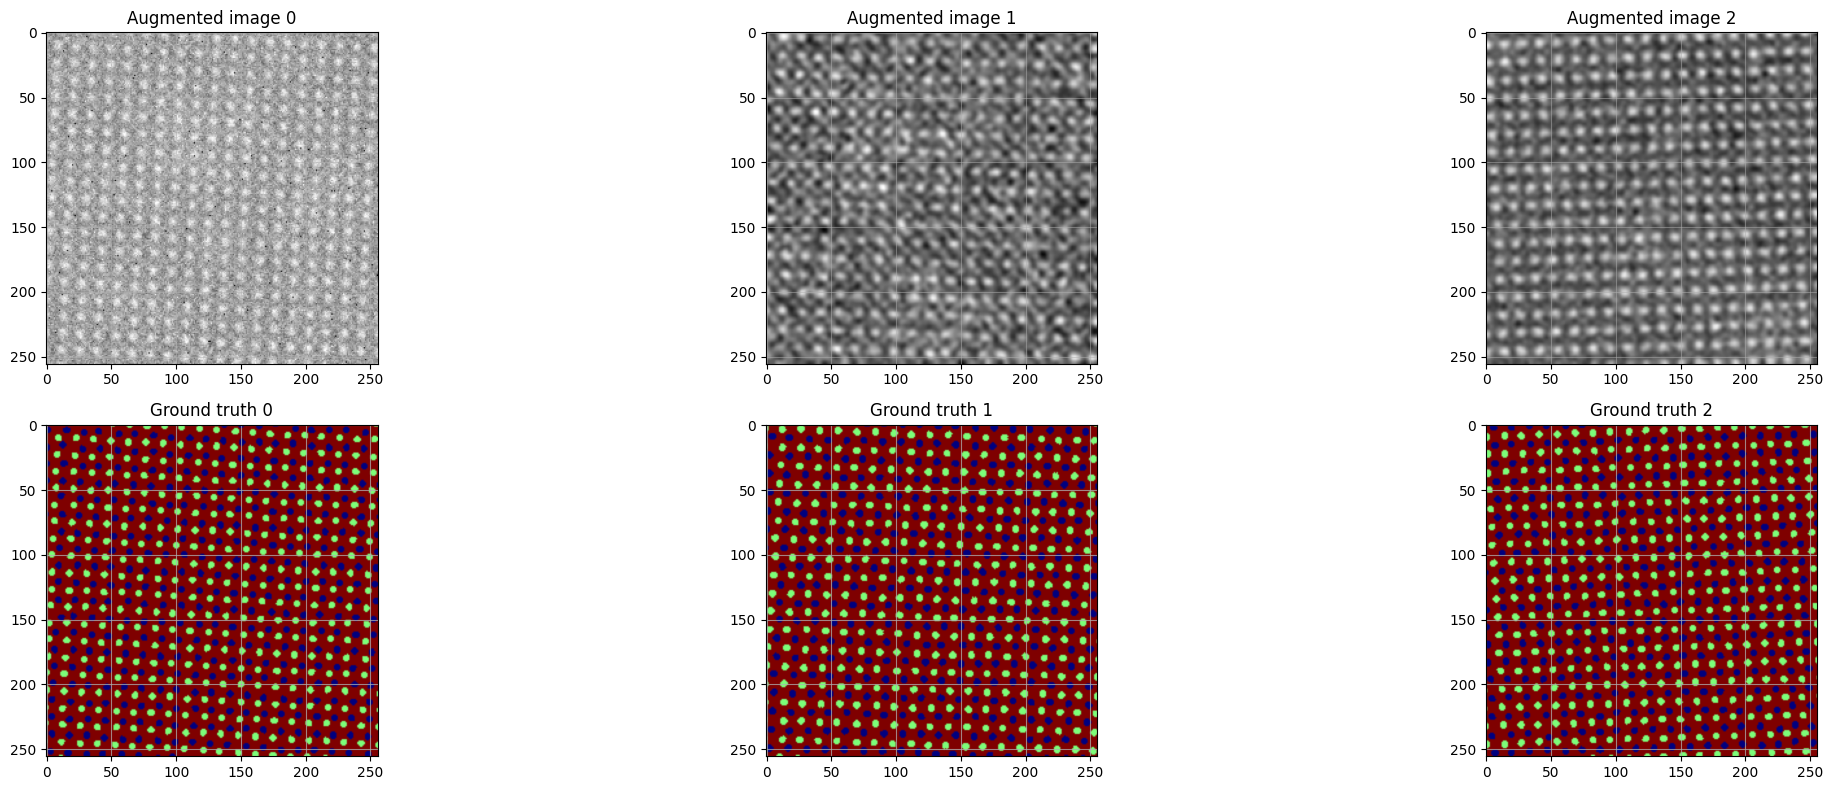

In [12]:
n = 3
k=1
n = n + 1
fig = plt.figure( figsize=(30, 8))
for i in range(1, n):
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images[i-1+k,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i-1) )
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    if labels.shape[1] == 1:
        ax.imshow(labels[i-1+k, 0], cmap='jet', interpoltion='Gaussian')
    else:
        ax.imshow(labels[i-1+k], cmap='jet', interpolation='Gaussian')


    ax.set_title('Ground truth ' + str(i-1))
    ax.grid(alpha=0.75)
plt.tight_layout()

Initialize a model for semantic segmentation:

In [13]:
model = aoi.models.Segmentor(nb_classes=3) #load model with 3 classes

In [14]:
print(model.net)

Unet(
  (c1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c3): ConvBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

Train the initialized model:

(Here the accuracy is calculated as [Intersection over Union](https://en.wikipedia.org/wiki/Jaccard_index) (IoU) score, which is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between them)

## The model has multiple additional features:
- **auto_thresh (bool):
        Performs automatic binary threshold selection for optimal f1-score
- **ES (bool):
        Early stopping mode on/off
- **patience (int):
         patience for early stopping
- **tolerance (float):
         tolerance for early stopping
- **weight_decay (float):
          weight decay for model

In the reusability report article the parameters training cycles and patience are set to 5000 and 500, respectively. The number of augmented images were ~ 2500. In this example notebooks, the parameters like training cycles, patience, number of augmented images created are modified to run without any premium GPU resources. This is done for “EarlyStopping_HRTEM_pv.ipynb" as well.

# Early stopping:
- The implemented Early stopping module has a few related kwargs. These can be set by the user.

- Stochastic weight averaging is not implemented for Early stopping Model, so it must be set to false, else ES will not run. The default value for swa is False, so the user does not explicitly have to set swa to False, but we have done so for demonstartion purposes. If swa is set to true, early stopping will not occur, and the model will run to completion.

- Tolerance is how much minimum improvement is necessary to be considered as an improvement.

- Paitence is how many epochs the model runs for without improvement before terminating. This is done in an attempt to prevent the model settling in a local minima, and resulting in sub-par performance


Epoch 1/3000 ... Training loss: 1.267527 ... Test loss: 1.219433 ... Train Accuracy: 0.094682 ... Test Accuracy: 0.038637 ... GPU memory usage: 2810/15360
Updating ES model @ Epoch 1/3000 ... Training loss: 1.267527 ... Test loss: 1.219433 ... Train Accuracy: 0.094682 ... Test Accuracy: 0.038637 ... GPU memory usage: 2810/15360
Updating ES model @ Epoch 12/3000 ... Training loss: 1.018013 ... Test loss: 1.21309 ... Train Accuracy: 0.270414 ... Test Accuracy: 0.031783 ... GPU memory usage: 3246/15360
Updating ES model @ Epoch 13/3000 ... Training loss: 0.9919 ... Test loss: 1.211651 ... Train Accuracy: 0.298936 ... Test Accuracy: 0.040114 ... GPU memory usage: 3246/15360
Updating ES model @ Epoch 14/3000 ... Training loss: 1.030995 ... Test loss: 1.188551 ... Train Accuracy: 0.244279 ... Test Accuracy: 0.031783 ... GPU memory usage: 3246/15360
Updating ES model @ Epoch 17/3000 ... Training loss: 0.952684 ... Test loss: 1.157386 ... Train Accuracy: 0.321642 ... Test Accuracy: 0.03968 ...

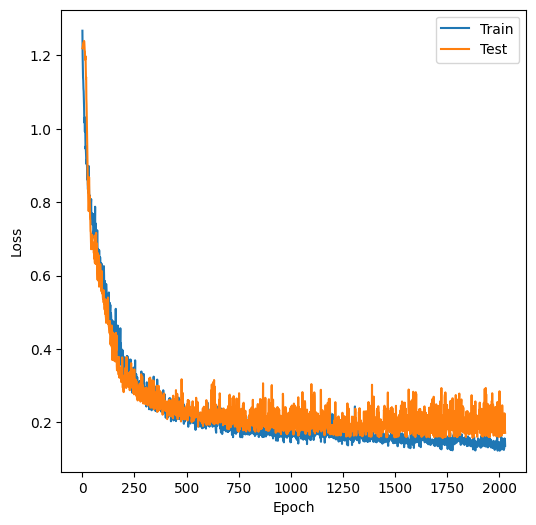

In [15]:
#set auto_thresh = false, as current implementation only works for the binary case
model.fit(images, labels, images_val, labels_val, # training data
          training_cycles=3000, compute_accuracy=True, batch_size=16, swa=False, filename='ES_reg',
          ES=True, patience=300,tolerance=1e-4,verbose=True,auto_thresh=False)

# In AtomAI by default the validation set is also evaluated on mini-batch. Set full_epoch=True if you want validation error to be reported for the full validation set (preferred when ES=True).
# model.fit(images, labels, images_val, labels_val, # training data
#          training_cycles=3000, compute_accuracy=True, batch_size=16, swa=False, filename='ES_reg',
#          ES=True, patience=50,tolerance=1e-4,verbose=True,auto_thresh=False, full_epoch=True)

# Predictions
 We use the early stopping model to predict on ```images_test```

In [ ]:
# model=aoi.load_model('ES_reg_metadict_final.tar')#can load the model from saved file

In [16]:
pred=model.predict(images_test) #user can provide threshold as well

Batch 236/236
236 images were decoded in approximately 3.0883 seconds


Auto-thresholding is currently only implemented for binary-class

In [33]:
type(pred[0]),type(labels_test)

(numpy.ndarray, numpy.ndarray)

In [37]:
pred[0]

array([[[[4.42947559e-02, 9.36968207e-01, 1.87369995e-02],
         [8.19433779e-02, 3.78377676e-01, 5.39678872e-01],
         [6.23557530e-02, 3.07439834e-01, 6.30204380e-01],
         ...,
         [1.89771794e-03, 3.95024978e-02, 9.58599806e-01],
         [1.43782273e-02, 1.00209303e-01, 8.85412395e-01],
         [3.37065011e-02, 2.39214525e-01, 7.27078974e-01]],

        [[3.47469375e-02, 9.65210974e-01, 4.20943761e-05],
         [6.29891083e-02, 9.16089058e-01, 2.09218785e-02],
         [8.04012716e-02, 4.54317003e-01, 4.65281725e-01],
         ...,
         [1.95026654e-03, 1.22527033e-02, 9.85796988e-01],
         [4.62504756e-03, 1.84609760e-02, 9.76913989e-01],
         [9.33551136e-03, 6.15067855e-02, 9.29157734e-01]],

        [[2.37986781e-02, 9.76050556e-01, 1.50801294e-04],
         [3.78007926e-02, 9.54145551e-01, 8.05371348e-03],
         [4.44830656e-02, 5.42295575e-01, 4.13221329e-01],
         ...,
         [1.88181223e-03, 4.58048983e-03, 9.93537724e-01],
         [

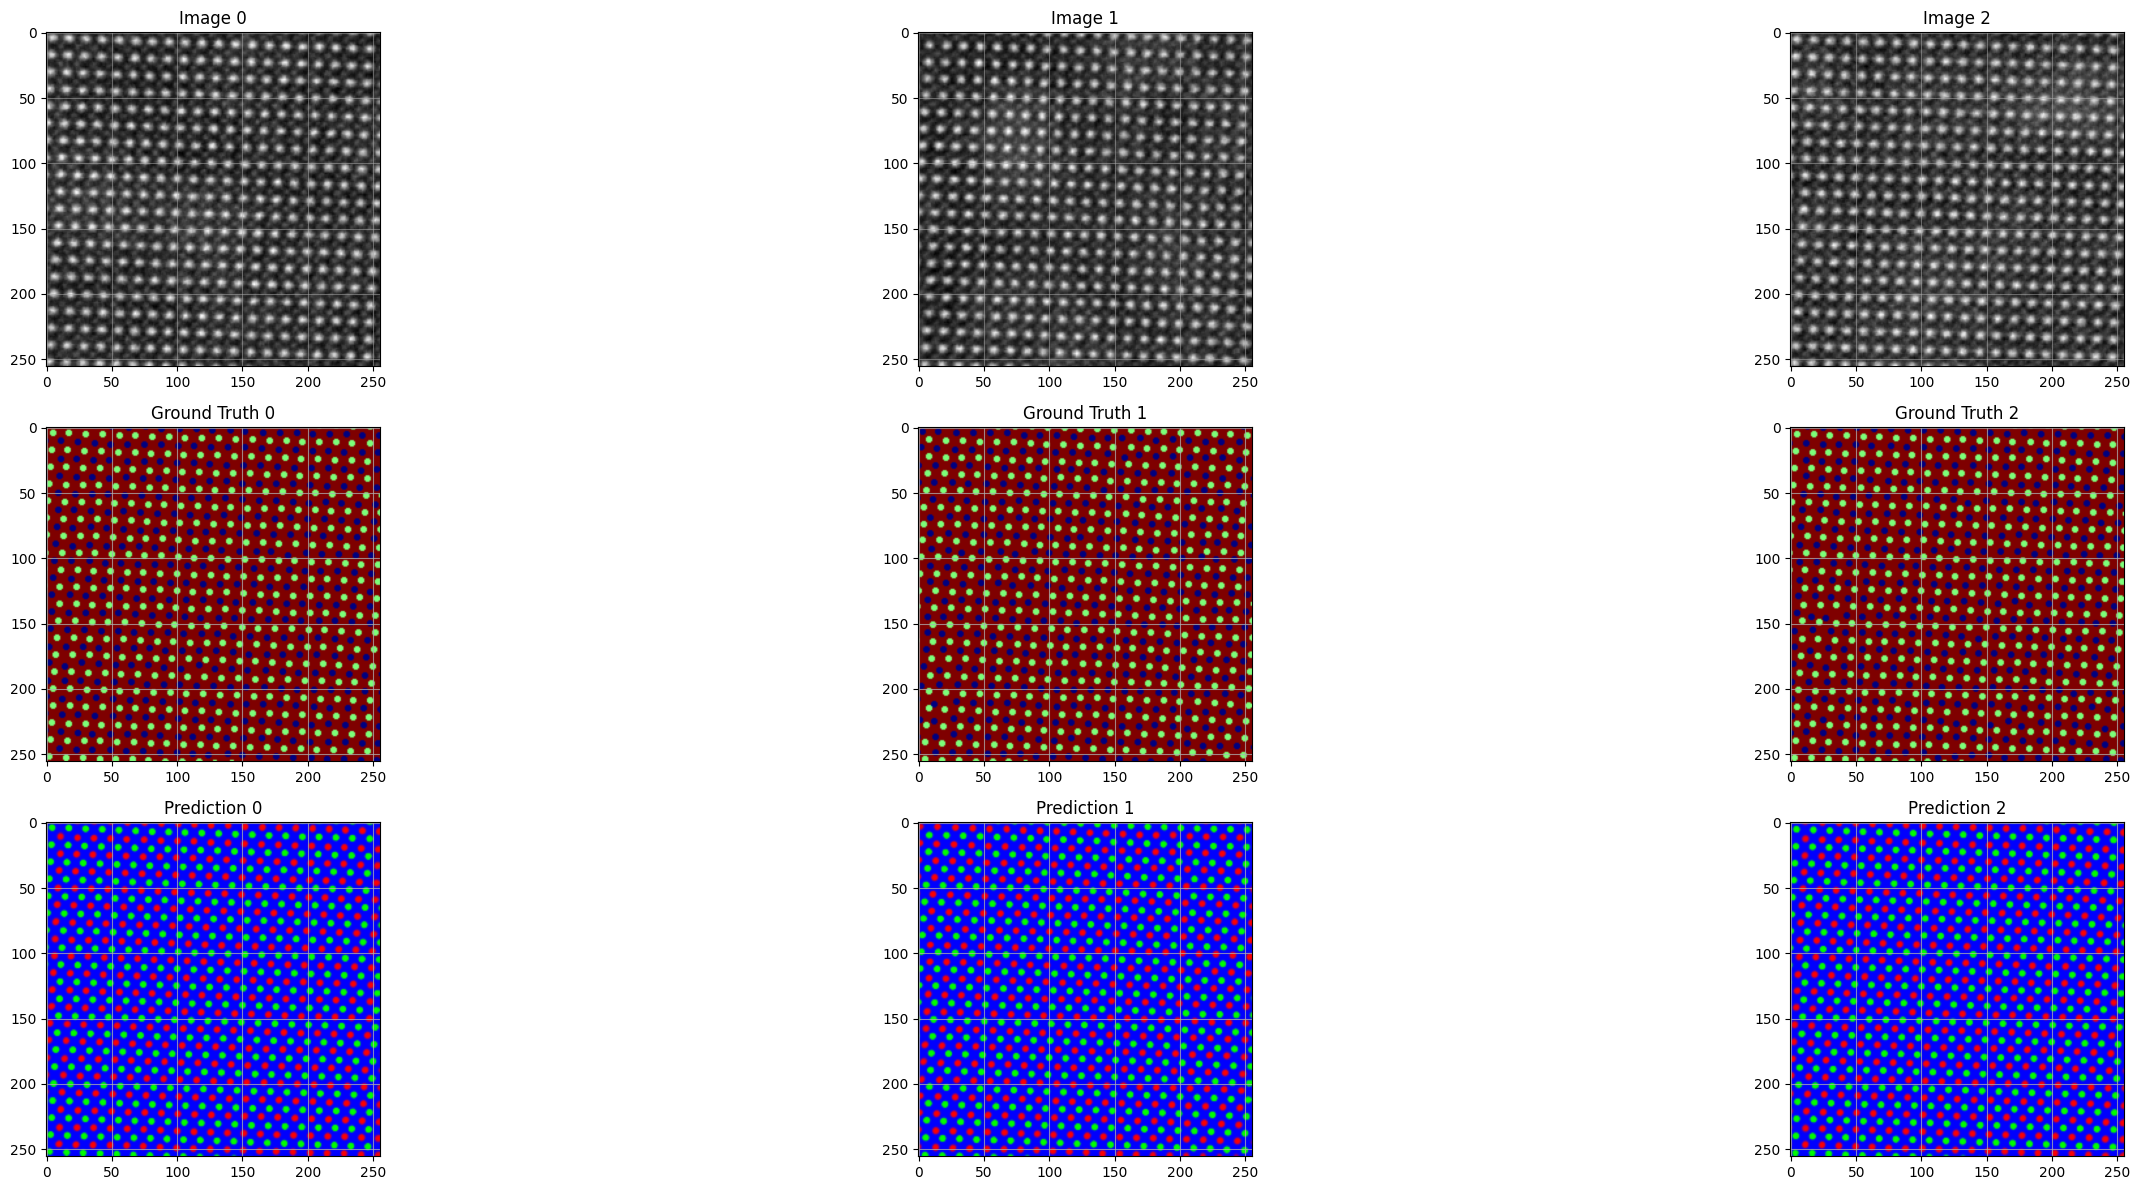

In [40]:
n = 3  # Number of samples to display
k = 1  # Offset for test set indexing
n = n + 1  # Adjusting for 1-based indexing (optional, but kept as in your original)

fig = plt.figure(figsize=(30, 12))  # Increased height for 3 rows

for i in range(1, n):
    # --- Row 1: Input Image ---
    ax = fig.add_subplot(3, n-1, i)  # 3 rows, (n-1) columns
    ax.imshow(images_test[i-1+k, 0, :, :], cmap='gray')
    ax.set_title('Image ' + str(i-1))
    ax.grid(alpha=0.5)

    # --- Row 2: Ground Truth ---
    ax = fig.add_subplot(3, n-1, i + (n-1))  # Second row
    if labels_test.shape[1] == 1:  # Check if labels are single-channel
        ax.imshow(labels_test[i-1+k, 0], cmap='jet', interpolation='Gaussian')
    else:
        ax.imshow(labels_test[i-1+k], cmap='jet', interpolation='Gaussian')
    ax.set_title('Ground Truth ' + str(i-1))
    ax.grid(alpha=0.75)

    # --- Row 3: Model Prediction ---
    ax = fig.add_subplot(3, n-1, i + 2*(n-1))  # Third row
    ax.imshow(pred[0][i-1+k], cmap='jet', interpolation='Gaussian')  # Assuming `pred` is your model output
    ax.set_title('Prediction ' + str(i-1))
    ax.grid(alpha=0.75)

plt.tight_layout()
plt.show()

In [ ]:
images.shape,labels.shape,images_test.shape,labels_test.shape

((423, 1, 256, 256), (423, 256, 256), (236, 1, 256, 256), (236, 256, 256))

In [ ]:
pred[0].shape,labels_test.shape

((236, 256, 256, 3), (236, 256, 256))

In [ ]:
plt.imshow(labels_test[0,])

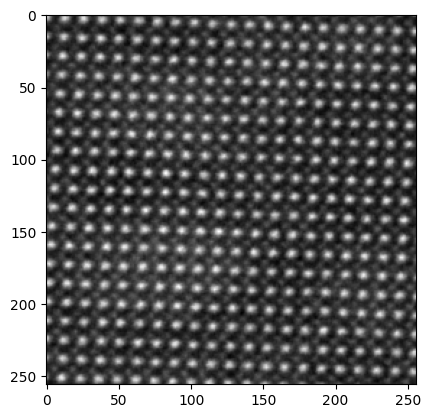

In [ ]:
plt.imshow(images_test[0,0,:,:], cmap='gray')

In [ ]:
pred[0][0]

array([[[1.4653362e-01, 8.1709009e-01, 3.6376320e-02],
        [1.1028647e-01, 6.7433810e-01, 2.1537539e-01],
        [6.5991655e-02, 2.1582103e-01, 7.1818739e-01],
        ...,
        [2.0824833e-02, 4.7517397e-02, 9.3165773e-01],
        [4.0490001e-02, 6.4718857e-02, 8.9479113e-01],
        [1.6418003e-01, 2.7872935e-01, 5.5709064e-01]],

       [[1.0628342e-01, 8.9113355e-01, 2.5829992e-03],
        [1.0427729e-01, 8.5004741e-01, 4.5675267e-02],
        [7.9634115e-02, 4.1115713e-01, 5.0920874e-01],
        ...,
        [5.8720289e-03, 7.3011979e-03, 9.8682678e-01],
        [7.2763613e-03, 1.0911134e-02, 9.8181248e-01],
        [2.7694326e-02, 5.1461689e-02, 9.2084402e-01]],

       [[4.5120433e-02, 9.5457834e-01, 3.0124994e-04],
        [4.6178490e-02, 9.4462019e-01, 9.2012547e-03],
        [4.8732344e-02, 4.3873778e-01, 5.1252991e-01],
        ...,
        [4.8201806e-03, 3.3181503e-03, 9.9186170e-01],
        [4.5295521e-03, 6.1440915e-03, 9.8932636e-01],
        [1.1673178e-02

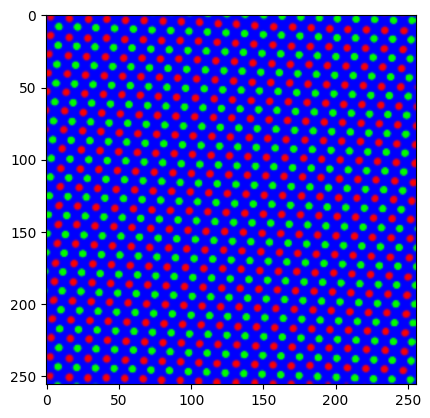

In [38]:
plt.imshow(pred[0][8], cmap='gray', interpolation='Gaussian')

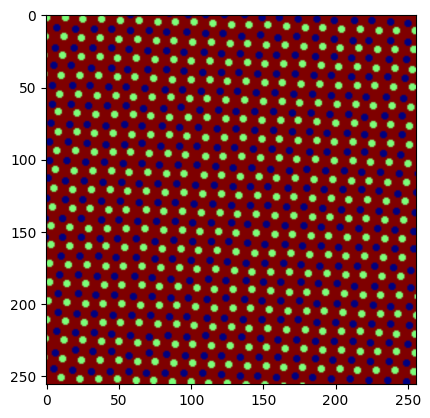

In [ ]:
plt.imshow(labels_test[0],cmap='jet',interpolation='Gaussian')